In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset
import torch
import torch.optim as optim
import os
from torchvision.models.resnet import ResNet, Bottleneck
import cv2
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate
from albumentations.pytorch import ToTensor
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Parameters

lr = 1e-5
img_size = 224
batch_size = 4
n_epochs = 10
coef = [0.5, 1.5, 2.5, 3.5]

In [3]:

# Functions

class RetinopathyDatasetTrain(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
#         img_name = os.path.join('../data/train_images', self.data.loc[idx, 'id_code'] + '.png')
#         image = cv2.imread(img_name)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, (img_size, img_size))
        img_path = os.path.join('../data/train_images/npy_rgb/', self.data.loc[idx, 'id_code'] + '.npy')
        image = np.load(img_path)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'])
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return {'image': image, 'labels': label}

class RetinopathyDatasetTest(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join('../data/test_images', self.data.loc[idx, 'id_code'] + '.png')
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_size, img_size))
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return {'image': image}


In [4]:
transform_train = Compose([
    HorizontalFlip(),
    Rotate(limit=365),
    VerticalFlip(),
    ToTensor()
])

transform_test = Compose([
    ToTensor()
])

train_dataset = RetinopathyDatasetTrain(csv_file='../data/train.csv', transform=transform_train)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [6]:
batch = next(iter(train_data_loader))

In [11]:
torch.max(batch['image'])

tensor(1.)

In [5]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 1)


Using cache found in /home/ags/.cache/torch/hub/facebookresearch_WSL-Images_master


In [6]:

criterion = torch.nn.MSELoss()
device = torch.device("cuda:0")
plist = [{'params': model.parameters(), 'lr': 1e-5}]
optimizer = optim.Adam(plist, lr=1e-5)

model = model.to(device)
model.train();


In [7]:

# Training

for epoch in range(n_epochs):

    nb_tr_steps = 0
    tr_loss = 0

    if epoch == 1:

        # Unfreeze lower layers after the first epoch

        for param in model.parameters():
            param.requires_grad = True

    for step, batch in enumerate(tqdm(train_data_loader)):

        inputs = batch["image"]
        labels = batch["labels"].view(-1, 1)

        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_steps += 1
    torch.cuda.empty_cache()


    epoch_loss = tr_loss / len(train_data_loader)
    print('Training Loss: {:.4f}'.format(epoch_loss))




Training Loss: 1.7041



Training Loss: 0.5887



Training Loss: 0.3560



Training Loss: 0.2714



Training Loss: 0.2367



Training Loss: 0.2293



Training Loss: 0.1855



Training Loss: 0.1709



Training Loss: 0.1615



Training Loss: 0.1342


####  Inference

In [9]:
# Inference

test_dataset = RetinopathyDatasetTest(csv_file='../data/sample_submission.csv', transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

for param in model.parameters():
    param.requires_grad = False

model.eval()

test_pred = np.zeros((len(test_dataset), 1))

for i, x_batch in enumerate(tqdm(test_data_loader)):
    x_batch = x_batch["image"]
    pred = model(x_batch.to(device))
    test_pred[i * batch_size:(i + 1) * batch_size] = pred.detach().cpu().squeeze().numpy().ravel().reshape(-1, 1)

for i, pred in enumerate(test_pred):
    if pred < coef[0]:
        test_pred[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        test_pred[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        test_pred[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        test_pred[i] = 3
    else:
        test_pred[i] = 4

sample = pd.read_csv("../data/sample_submission.csv")
sample.diagnosis = test_pred.astype(int)
sample.to_csv("submission.csv", index=False)

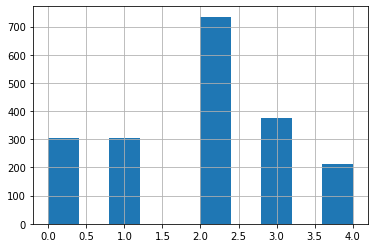

In [11]:
sample['diagnosis'].hist()

In [13]:
sample['diagnosis'].value_counts()

2    735
3    374
1    305
0    303
4    211
Name: diagnosis, dtype: int64